In [164]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

In [165]:
# Configurações de visualização
%matplotlib inline
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# --- Carregar o Dataset ---
# Usamos index_col='date' e parse_dates=True para que o Pandas
# entenda nosso dataset como uma série temporal.

FILE_NAME = '../data/dataset-final-final.csv'

try:
    df = pd.read_csv(FILE_NAME, index_col='date', parse_dates=True)
except FileNotFoundError:
    print(f"Erro: Arquivo '{FILE_NAME}' não encontrado.")
    # Se der erro, pare aqui e verifique o nome do arquivo.
    raise

print(f"Dataset '{FILE_NAME}' carregado com sucesso.")
print(f"Dimensão: {df.shape}")
print("\nPrimeiras 5 linhas:")

# Verificar se as colunas necessárias do Compound estão presentes
required_cols = ['total_deposit_usd', 'deposit_apy', 'utilization_rate']
if not all(col in df.columns for col in required_cols):
    print("\nERRO: Colunas do Compound não encontradas. Verifique seu merge.")
else:
    print("\nColunas do Compound validadas com sucesso.")

Dataset '../data/dataset-final-final.csv' carregado com sucesso.
Dimensão: (1002, 32)

Primeiras 5 linhas:

Colunas do Compound validadas com sucesso.


In [166]:
df.head()

,Y_Aave_APY,X_Aave_Utilization,totalValueLockedUSD,Y_SOFR,X_USDC_Depeg_Risk,X_BTC_Price,X_ETH_Price,X_VIX,X_DGS2,X_Gas_Price_Gwei,...,total_tvl_aave,total_tvl_compound,total_tvl_defi,apy_aave,apy_compound,DeFi_APY_Ponderado,Y_Target_Spread_Ponderado,Spread_Aave_Compound,compound_utilization_rate,delta_total_defi_tvl_7d
date,,,,,,,,,,,,,,,,,,,,,
2023-02-10,1.065206,0.516046,2.954084e+07,4.55,0.395367,21629.58,1513.90,20.53,4.50,29.368859,...,2.954084e+07,1.530275e+08,1.825683e+08,1.065206,2.469392,2.242184,-2.307816,-1.404186,75.981277,0.047703
2023-02-11,1.351110,0.581190,2.983011e+07,4.55,0.366080,21857.51,1538.26,20.53,4.50,21.415378,...,2.983011e+07,1.531180e+08,1.829482e+08,1.351110,2.407529,2.235278,-2.314722,-1.056419,74.077824,0.041050
2023-02-12,1.477193,0.607706,2.901072e+07,4.55,0.375003,21784.08,1514.41,20.53,4.50,21.067639,...,2.901072e+07,1.534786e+08,1.824893e+08,1.477193,2.394697,2.248840,-2.301160,-0.917504,73.682817,0.033322
2023-02-13,1.234612,0.555573,3.404628e+07,4.55,0.415355,21786.33,1506.71,20.34,4.52,29.595632,...,3.404628e+07,1.532760e+08,1.873223e+08,1.234612,2.199709,2.024301,-2.525699,-0.965098,67.678167,0.041849
2023-02-14,1.718342,0.655439,3.610464e+07,4.55,0.387936,22193.69,1557.20,18.91,4.60,64.056071,...,3.610464e+07,1.535504e+08,1.896550e+08,1.718342,2.200525,2.108732,-2.441268,-0.482184,67.708469,0.045900


[]

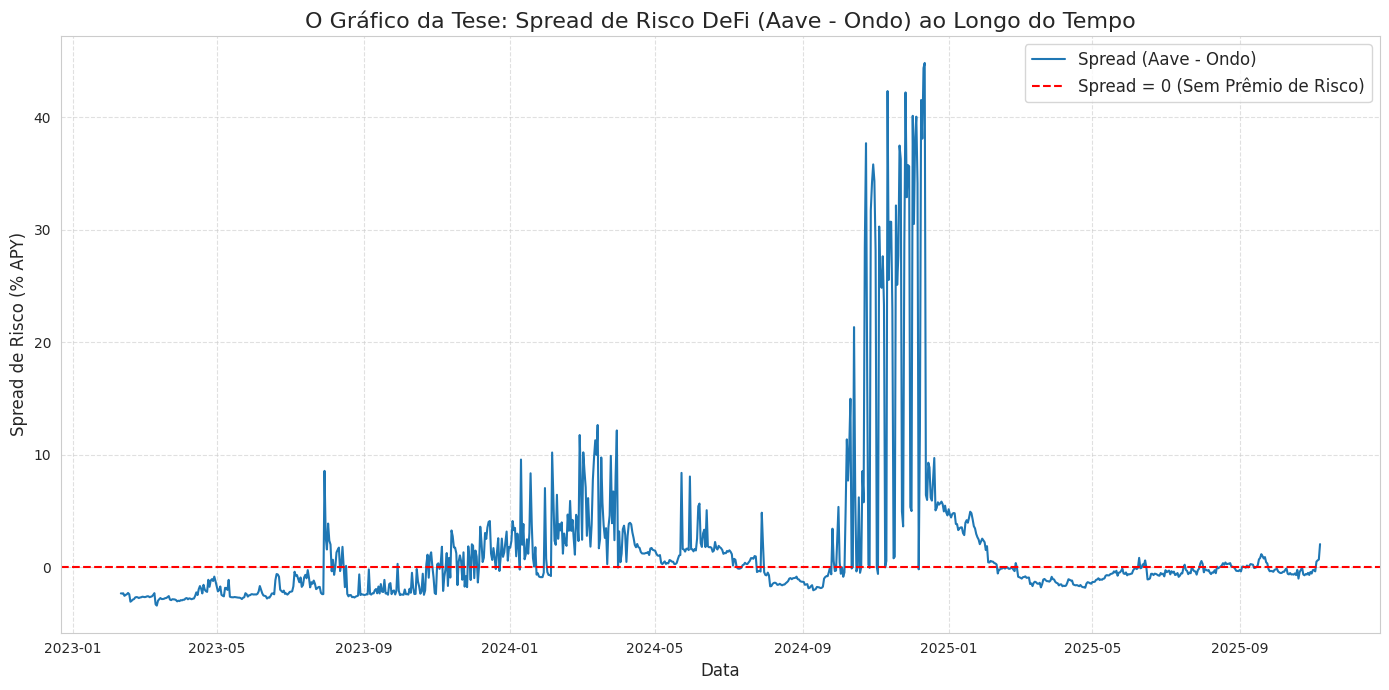

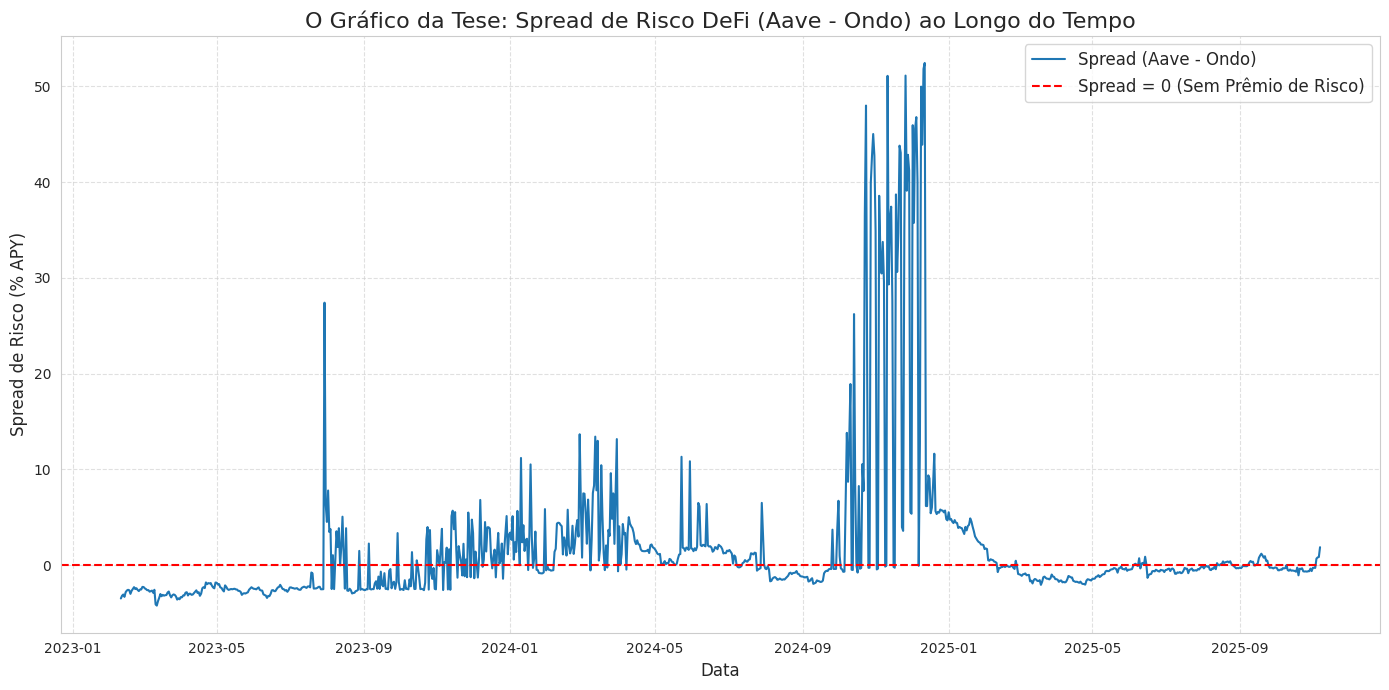

In [167]:
# --- 2. Preparar os Dados ---

# --- 3. Gerar "O Gráfico da Tese" (Plot de Série Temporal) ---
plt.figure(figsize=(14, 7))
ax = sns.lineplot(x=df.index, y=df['Y_Target_Spread_Ponderado'], label='Spread (Aave - Ondo)')

# Adicionar uma linha de base em 0
ax.axhline(0, ls='--', color='red', lw=1.5, label='Spread = 0 (Sem Prêmio de Risco)')

# Melhorar a formatação
plt.title('O Gráfico da Tese: Spread de Risco DeFi (Aave - Ondo) ao Longo do Tempo', fontsize=16)
plt.ylabel('Spread de Risco (% APY)', fontsize=12)
plt.xlabel('Data', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# Plotar o gráfico
plt.plot()


# --- 3. Gerar "O Gráfico da Tese" (Plot de Série Temporal) ---
plt.figure(figsize=(14, 7))
ax = sns.lineplot(x=df.index, y=df['Y_Target_Spread'], label='Spread (Aave - Ondo)')

# Adicionar uma linha de base em 0
ax.axhline(0, ls='--', color='red', lw=1.5, label='Spread = 0 (Sem Prêmio de Risco)')

# Melhorar a formatação
plt.title('O Gráfico da Tese: Spread de Risco DeFi (Aave - Ondo) ao Longo do Tempo', fontsize=16)
plt.ylabel('Spread de Risco (% APY)', fontsize=12)
plt.xlabel('Data', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# Plotar o gráfico
plt.plot()

# Features old

In [168]:
# Bloco 2: Engenharia de Features (Alvo Ponderado e Features de Cluster)

print("Iniciando Engenharia de Features...")

# --- 1. Criar o Alvo Ponderado (y) ---
# Usamos os TVLs (totalValueLockedUSD e total_deposit_usd) como pesos.

# Pesos (TVLs)
tvl_aave = df['totalValueLockedUSD']
tvl_compound = df['total_deposit_usd']
total_tvl_defi = tvl_aave + tvl_compound

# APYs
apy_aave = df['Y_Aave_APY']
apy_compound = df['deposit_apy']

# Cálculo do APY Ponderado
df['DeFi_APY_Ponderado'] = ((apy_aave * tvl_aave) + (apy_compound * tvl_compound)) / total_tvl_defi

# Cálculo do Novo Alvo (Spread Ponderado)
df['Y_Target_Spread_Ponderado'] = df['DeFi_APY_Ponderado'] - df['Y_SOFR']
print("Novo alvo 'Y_Target_Spread_Ponderado' criado.")

# --- 2. Criar Novas Features de Clusterização (X) ---
# O 'X_' no início ajuda a identificar features.

# Feature 1: Spread Interno DeFi (Aave vs Compound)
df['X_Spread_Aave_Compound'] = apy_aave - apy_compound

# Feature 2: Variação % do TVL DeFi (Fluxo de Capital em 7 dias)
df['X_Delta_TVL_DeFi_7D_pct'] = total_tvl_defi.pct_change(7)

# Feature 3: Renomear a utilização do Compound para o padrão 'X_'
df['X_Compound_Utilization'] = df['utilization_rate']

# --- 3. Limpeza Pós-Engenharia ---
# A feature 'X_Delta_TVL_DeFi_7D_pct' criou NaNs nas primeiras 7 linhas.
# Vamos removê-los para ter um dataset 100% limpo para modelagem.
df_model = df.dropna()

print("Novas features 'X_' para clusterização criadas.")
print(f"Dimensão final do dataset (pós-NaN drop): {df_model.shape}")

# É uma boa prática salvar este dataset final
df_model.to_csv('dataset_para_modelagem.csv')
print("Dataset final 'dataset_para_modelagem.csv' salvo.")

Iniciando Engenharia de Features...
Novo alvo 'Y_Target_Spread_Ponderado' criado.
Novas features 'X_' para clusterização criadas.
Dimensão final do dataset (pós-NaN drop): (995, 35)
Dataset final 'dataset_para_modelagem.csv' salvo.


# Features

In [169]:
# Bloco 3: Definição e Seleção de Features (X) e Alvo (y)

# 1. Defina sua variável alvo (y)
TARGET_COLUMN = 'Y_Target_Spread_Ponderado'
y = df_model[TARGET_COLUMN]

# 2. Selecione as features para o modelo (X)
# Esta é a etapa de "Feature Selection"
# Inclua suas features antigas + as novas que criamos
FEATURE_COLUMNS = [
    # --- Features Antigas (TradFi + Aave) ---
    'X_Aave_Utilization',
    'X_USDC_Depeg_Risk',
    # 'X_BTC_Price',  # Preços absolutos podem ser ruins para clusterização
    # 'X_ETH_Price',
    'X_VIX',
    'X_DGS2',
    'X_Gas_Price_Gwei',
    'X_ETH_Returns',
    'X_ETH_Vol_7D',
    'X_BTC_Returns',
    'X_BTC_Vol_7D',
    'X_Gas_MA_7D',
    'X_VIX_Pct_Change',

    # --- NOVAS FEATURES (Compound + Mercado) ---
    'X_Compound_Utilization',   # Stress/Demanda no Compound
    'X_Spread_Aave_Compound',   # Fricção interna do DeFi
    'X_Delta_TVL_DeFi_7D_pct' # Fluxo de Capital/Momentum
]

# Garantir que estamos usando apenas colunas que realmente existem
features_existentes = [col for col in FEATURE_COLUMNS if col in df_model.columns]
X = df_model[features_existentes]

print(f"Total de features selecionadas para X: {len(features_existentes)}")

# 3. Padronizar (Standardize) as features
# O KMeans é sensível à escala, então este passo é OBRIGATÓRIO.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Converter de volta para DataFrame para facilitar a análise
X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

print("\nFeatures (X) selecionadas e padronizadas (X_scaled).")
print(X_scaled.head())

Total de features selecionadas para X: 14

Features (X) selecionadas e padronizadas (X_scaled).
            X_Aave_Utilization  X_USDC_Depeg_Risk     X_VIX    X_DGS2  \
date                                                                    
2023-02-17           -1.449469           0.350070  0.699822  0.652268   
2023-02-18           -2.192862           0.298208  0.699822  0.652268   
2023-02-19           -1.550196           0.344430  0.699822  0.652268   
2023-02-20           -1.221570           0.281414  0.974762  0.652268   
2023-02-21           -0.872865           0.180244  1.347409  0.802595   

            X_Gas_Price_Gwei  X_ETH_Returns  X_ETH_Vol_7D  X_BTC_Returns  \
date                                                                       
2023-02-17          1.062259       1.014580      0.321129       1.826336   
2023-02-18          0.573815      -0.085854      0.365833       0.033749   
2023-02-19          0.524817      -0.220640      0.290554      -0.585932   
2023-02-20  

## CLuster

In [170]:
# Bloco 4: Divisão Treino/Teste e Clusterização (Fit no Treino)

# 1. Definir o ponto de corte para treino/teste (Split Temporal)
# Usando 80% dos dados para treino, 20% para teste
split_index = int(len(df_model) * 0.8)

# --- Dividir TODOS os dataframes ---

# Dados padronizados (para KMeans)
X_train_scaled = X_scaled.iloc[:split_index]
X_test_scaled = X_scaled.iloc[split_index:]

# Dados brutos (para o Lasso)
X_raw = df_model[features_existentes] # Re-selecionar do df_model
X_train_raw = X_raw.iloc[:split_index]
X_test_raw = X_raw.iloc[split_index:]

# Alvo (y)
y_train = y.iloc[:split_index]
y_test = y.iloc[split_index:]

# DataFrames completos (para análise e plots)
df_train = df_model.iloc[:split_index].copy()
df_test = df_model.iloc[split_index:].copy()

print(f"Dados divididos: {len(df_train)} treino, {len(df_test)} teste.")
print(f"Data de corte: {df_test.index[0]}")

# 2. Treinar o modelo KMeans (APENAS NO TREINO)
N_CLUSTERS = 3 # 3 regimes (Calmo, Stress, Pânico)
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=42, n_init=10)

# 3. Fit (treino) e Predict (teste)
print(f"--- Treinando K-Means (k={N_CLUSTERS}) nos dados de TREINO ---")
train_regimes = kmeans.fit_predict(X_train_scaled)
print("--- Aplicando clusters aprendidos aos dados de TESTE ---")
test_regimes = kmeans.predict(X_test_scaled)

# 4. Adicionar os clusters aos DataFrames de treino/teste
df_train = df_train.assign(cluster=train_regimes)
df_test = df_test.assign(cluster=test_regimes)

print("\nClusterização concluída e aplicada a treino/teste.")

Dados divididos: 796 treino, 199 teste.
Data de corte: 2025-04-23 00:00:00
--- Treinando K-Means (k=3) nos dados de TREINO ---
--- Aplicando clusters aprendidos aos dados de TESTE ---

Clusterização concluída e aplicada a treino/teste.



--- Análise dos Centroides (Média das features Z-score por cluster) ---
cluster                         0         1         2
X_Aave_Utilization       0.459276 -1.252636  1.507265
X_USDC_Depeg_Risk       -0.274421 -0.074872  0.227544
X_VIX                   -0.414623  0.826864 -0.160890
X_DGS2                   0.597592 -0.330996 -0.189125
X_Gas_Price_Gwei         0.456738 -0.339989  0.085402
X_ETH_Returns           -0.026623 -0.059717  0.297879
X_ETH_Vol_7D            -0.316568  0.407553  0.474625
X_BTC_Returns           -0.016673  0.027437  0.311678
X_BTC_Vol_7D            -0.065716  0.554579  0.432425
X_Gas_MA_7D              0.495173 -0.349443 -0.045141
X_VIX_Pct_Change        -0.036193  0.148606 -0.150971
X_Compound_Utilization   0.444473 -1.398608  0.586762
X_Spread_Aave_Compound  -0.166797 -0.201177  4.575180
X_Delta_TVL_DeFi_7D_pct  0.044440 -0.058964  0.185465



Heatmap dos centroides salvo como 'cluster_centroids_heatmap.png'


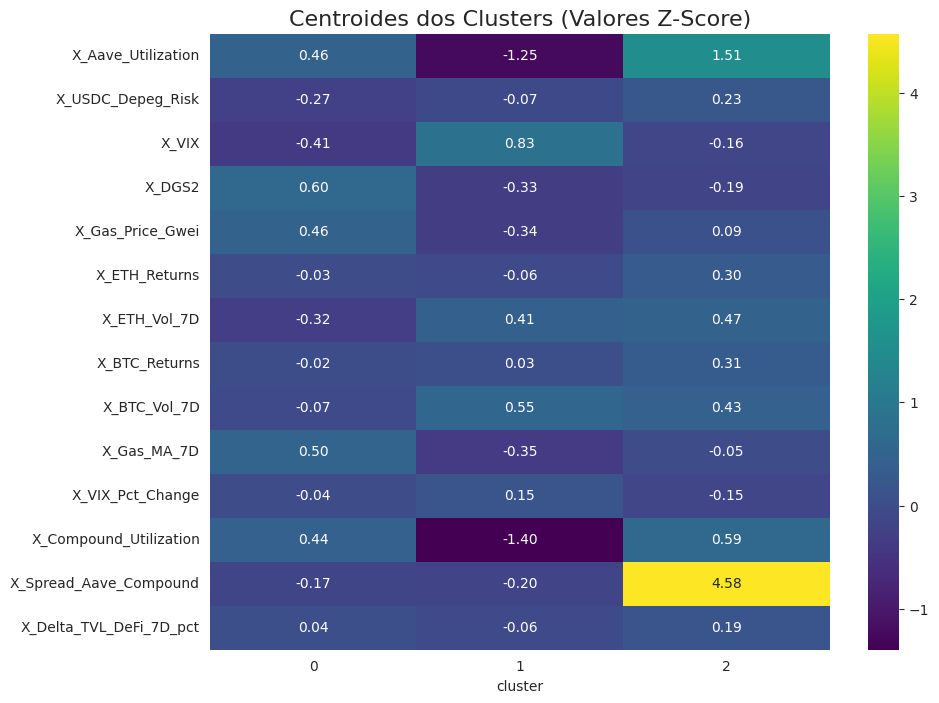

In [171]:
# Bloco 5: Análise dos Centroides (O que cada cluster significa?)

# Criar um dataframe de análise com os dados de treino padronizados
X_train_analysis = X_train_scaled.copy()
X_train_analysis['cluster'] = train_regimes

# Agrupar por cluster e calcular a média (centroides)
# Usamos os dados padronizados (X_train_scaled) para a análise,
# pois as médias dos dados brutos teriam escalas diferentes.
cluster_centers = X_train_analysis.groupby('cluster').mean().T

print("\n--- Análise dos Centroides (Média das features Z-score por cluster) ---")
print(cluster_centers)

# Plotar um heatmap para visualizar facilmente
plt.figure(figsize=(10, 8))
sns.heatmap(cluster_centers, annot=True, cmap='viridis', fmt='.2f')
plt.title('Centroides dos Clusters (Valores Z-Score)', fontsize=16)
plt.plot()
print("\nHeatmap dos centroides salvo como 'cluster_centroids_heatmap.png'")

Plotando áreas dos regimes (axvspan)...
Gráfico de regimes salvo como 'spread_com_regimes_kmeans.png'


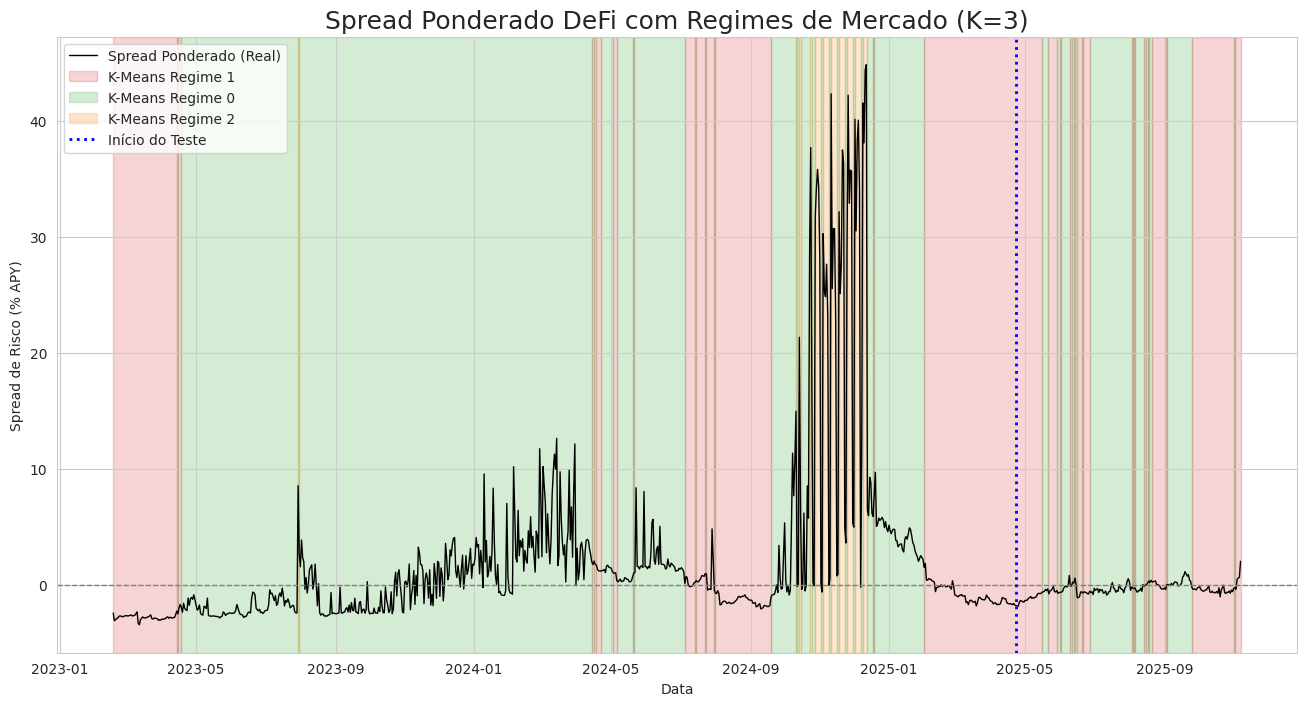

In [172]:
# Bloco 6: Visualização dos Regimes de Mercado (axvspan plot)

# 1. Juntar treino e teste para plotagem contínua
df_plot = pd.concat([df_train, df_test])

# 2. Configurações de Plotagem
plt.figure(figsize=(16, 8))
# Usamos nosso NOVO alvo ponderado
target_plot_column = 'Y_Target_Spread_Ponderado'
# Cores para 3 clusters
colors = ['#2ca02c', '#d62728', '#ff7f0e'] # Verde, Vermelho, Laranja
regime_names = [f'K-Means Regime {i}' for i in range(N_CLUSTERS)]

# 3. Plotar a linha do Spread
ax = sns.lineplot(data=df_plot, x=df_plot.index, y=target_plot_column, 
                  label='Spread Ponderado (Real)', color='black', linewidth=1.0)
ax.axhline(0, ls='--', color='grey', lw=1)

# 4. Loop para colorir o fundo (axvspan) - Lógica do seu notebook
print("Plotando áreas dos regimes (axvspan)...")
plotted_labels = set()
start_date = df_plot.index[0]
current_regime = df_plot.iloc[0]['cluster']

for i in range(1, len(df_plot)):
    row = df_plot.iloc[i]
    if row['cluster'] != current_regime:
        end_date = df_plot.index[i]
        label = regime_names[int(current_regime)] if regime_names[int(current_regime)] not in plotted_labels else None
        
        ax.axvspan(start_date, end_date, color=colors[int(current_regime)], 
                   alpha=0.2, label=label, zorder=0)
        
        plotted_labels.add(regime_names[int(current_regime)])
        start_date = end_date
        current_regime = row['cluster']

# Plotar o último bloco
label = regime_names[int(current_regime)] if regime_names[int(current_regime)] not in plotted_labels else None
ax.axvspan(start_date, df_plot.index[-1], color=colors[int(current_regime)], 
           alpha=0.2, label=label, zorder=0)

# 5. Linha de Divisão Treino/Teste
split_date = df_test.index[0]
ax.axvline(split_date, color='blue', linestyle=':', linewidth=2, label='Início do Teste')

# 6. Finalizar o Gráfico
ax.legend(loc='upper left')
plt.title(f'Spread Ponderado DeFi com Regimes de Mercado (K={N_CLUSTERS})', fontsize=18)
plt.ylabel('Spread de Risco (% APY)')
plt.xlabel('Data')
plt.plot()
print("Gráfico de regimes salvo como 'spread_com_regimes_kmeans.png'")
plt.show()


--- Iniciando Treinamento de Modelos por Cluster ---

Treinando modelo para o Cluster 0...
Modelo para Cluster 0 treinado.

Treinando modelo para o Cluster 1...
Modelo para Cluster 1 treinado.

Treinando modelo para o Cluster 2...
Modelo para Cluster 2 treinado.

--- Avaliação Final do Modelo Clusterizado ---
MAE (Erro Médio Absoluto): 0.8583
R² (Score): -2.7563
Gráfico de predição salvo como 'predicao_vs_real_clusterizado.png'


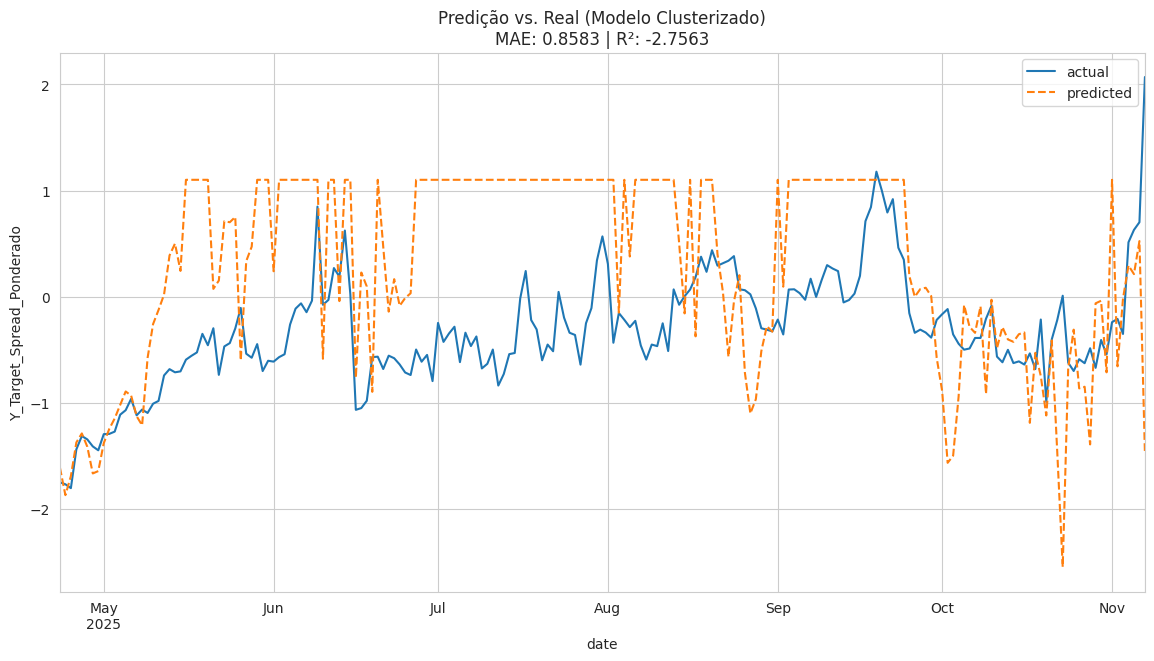

In [173]:
# Bloco 7: Modelagem (Treinando um Regressor por Cluster)

print("\n--- Iniciando Treinamento de Modelos por Cluster ---")

models_by_cluster = {}

for cluster_id in range(N_CLUSTERS):
    print(f"\nTreinando modelo para o Cluster {cluster_id}...")
    
    # Filtrar dados de treino para este cluster
    X_train_cluster = X_train_raw[df_train['cluster'] == cluster_id]
    y_train_cluster = y_train[df_train['cluster'] == cluster_id]
    
    if len(X_train_cluster) < 10: 
        print(f"Cluster {cluster_id} tem poucos dados de treino. Pulando.")
        continue
        
    # Treinar o modelo (LassoCV) - Usamos os dados NÃO padronizados
    model = LassoCV(cv=5, random_state=42, max_iter=2000, n_jobs=-1)
    model.fit(X_train_cluster, y_train_cluster)
    
    models_by_cluster[cluster_id] = model
    print(f"Modelo para Cluster {cluster_id} treinado.")

# --- Avaliação nos dados de teste ---
predictions = pd.Series(index=X_test_raw.index, dtype=float, name="predicted")

for cluster_id, model in models_by_cluster.items():
    # Encontrar quais dias de TESTE pertencem a este cluster
    X_test_cluster = X_test_raw[df_test['cluster'] == cluster_id]
    
    if not X_test_cluster.empty:
        preds_cluster = model.predict(X_test_cluster)
        predictions.loc[X_test_cluster.index] = preds_cluster

# --- Calcular métricas finais ---
results = pd.DataFrame({'actual': y_test, 'predicted': predictions}).dropna()

mae = mean_absolute_error(results['actual'], results['predicted'])
r2 = r2_score(results['actual'], results['predicted'])

print("\n--- Avaliação Final do Modelo Clusterizado ---")
print(f"MAE (Erro Médio Absoluto): {mae:.4f}")
print(f"R² (Score): {r2:.4f}")

# --- Plotar resultados da predição ---
results.plot(figsize=(14, 7), 
             title=f'Predição vs. Real (Modelo Clusterizado)\nMAE: {mae:.4f} | R²: {r2:.4f}',
             style=['-', '--'])
plt.ylabel(TARGET_COLUMN)
plt.legend()
plt.plot()
print("Gráfico de predição salvo como 'predicao_vs_real_clusterizado.png'")
plt.show()

## 2 clusters

=== RE-RODANDO MODELO COM N_CLUSTERS = 2 ===
--- Treinando K-Means (k=2) nos dados de TREINO ---
--- Aplicando clusters aprendidos aos dados de TESTE ---

Gráfico de 2 regimes salvo como 'spread_com_2_regimes_kmeans.png'


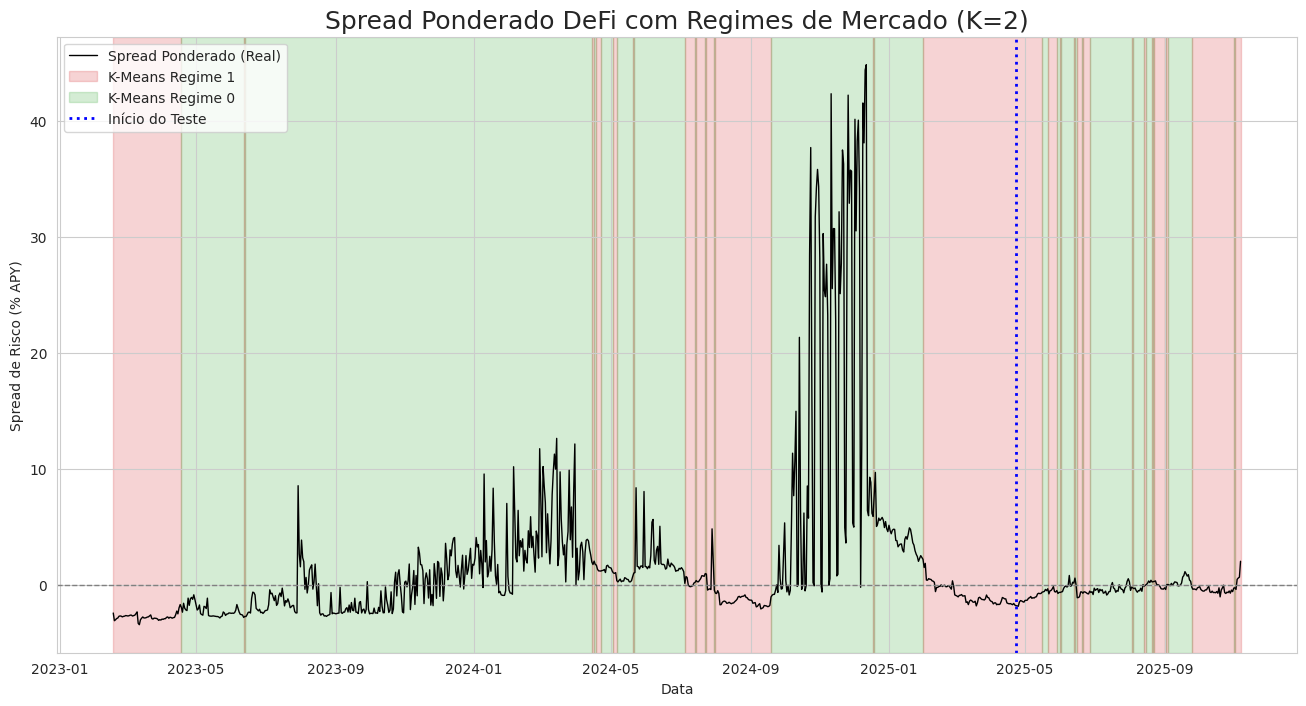


--- Iniciando Treinamento de Modelos por Cluster (k=2) ---
Treinando modelo para o Cluster 0...
Modelo para Cluster 0 treinado.
Treinando modelo para o Cluster 1...
Modelo para Cluster 1 treinado.

--- Avaliação Final do Modelo (k=2) ---
MAE (Erro Médio Absoluto): 1.7959
R² (Score): -18.5947
Gráfico de predição (k=2) salvo como 'predicao_vs_real_k2.png'


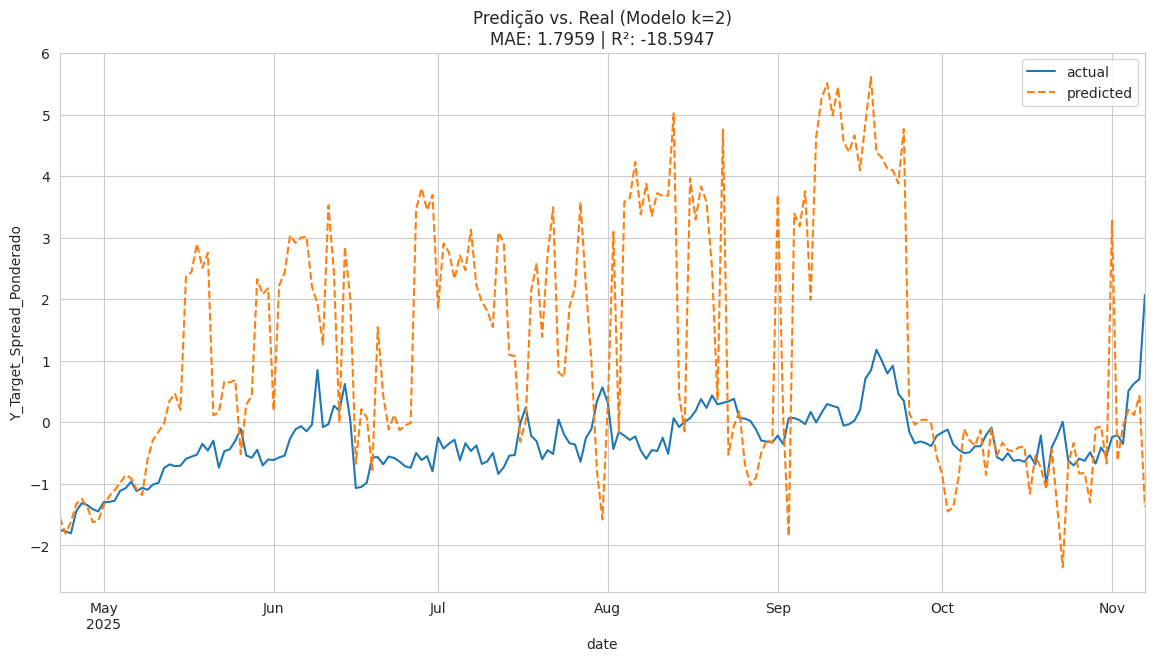

In [174]:
# Bloco Único: Re-rodar com N_CLUSTERS = 2

# --- 1. Definir o N de Clusters ---
N_CLUSTERS = 2
print(f"=== RE-RODANDO MODELO COM N_CLUSTERS = {N_CLUSTERS} ===")

# --- 2. Preparar DataFrames (já devem estar na memória) ---
# X_train_scaled, X_test_scaled, X_train_raw, X_test_raw, y_train, y_test
# df_train, df_test

# --- 3. Treinar o K-Means (Fit no Treino, Predict no Teste) ---
kmeans_2 = KMeans(n_clusters=N_CLUSTERS, random_state=42, n_init=10)

print(f"--- Treinando K-Means (k={N_CLUSTERS}) nos dados de TREINO ---")
train_regimes_2 = kmeans_2.fit_predict(X_train_scaled)
print("--- Aplicando clusters aprendidos aos dados de TESTE ---")
test_regimes_2 = kmeans_2.predict(X_test_scaled)

# Adicionar os NOVOS clusters (sobrescrever a coluna 'cluster')
df_train = df_train.assign(cluster=train_regimes_2)
df_test = df_test.assign(cluster=test_regimes_2)

# --- 4. Visualização dos 2 Regimes (Gráfico axvspan) ---
df_plot_2 = pd.concat([df_train, df_test])

plt.figure(figsize=(16, 8))
target_plot_column = 'Y_Target_Spread_Ponderado'
colors = ['#2ca02c', '#d62728'] # Verde (Calmo), Vermelho (Volátil)
regime_names = [f'K-Means Regime {i}' for i in range(N_CLUSTERS)]

ax = sns.lineplot(data=df_plot_2, x=df_plot_2.index, y=target_plot_column, 
                  label='Spread Ponderado (Real)', color='black', linewidth=1.0)
ax.axhline(0, ls='--', color='grey', lw=1)

plotted_labels = set()
start_date = df_plot_2.index[0]
current_regime = df_plot_2.iloc[0]['cluster']

for i in range(1, len(df_plot_2)):
    row = df_plot_2.iloc[i]
    if row['cluster'] != current_regime:
        end_date = df_plot_2.index[i]
        label = regime_names[int(current_regime)] if regime_names[int(current_regime)] not in plotted_labels else None
        ax.axvspan(start_date, end_date, color=colors[int(current_regime)], 
                   alpha=0.2, label=label, zorder=0)
        plotted_labels.add(regime_names[int(current_regime)])
        start_date = end_date
        current_regime = row['cluster']

# Último bloco
label = regime_names[int(current_regime)] if regime_names[int(current_regime)] not in plotted_labels else None
ax.axvspan(start_date, df_plot_2.index[-1], color=colors[int(current_regime)], 
           alpha=0.2, label=label, zorder=0)

split_date = df_test.index[0]
ax.axvline(split_date, color='blue', linestyle=':', linewidth=2, label='Início do Teste')
ax.legend(loc='upper left')
plt.title(f'Spread Ponderado DeFi com Regimes de Mercado (K={N_CLUSTERS})', fontsize=18)
plt.ylabel('Spread de Risco (% APY)')
plt.xlabel('Data')
plt.plot()
print("\nGráfico de 2 regimes salvo como 'spread_com_2_regimes_kmeans.png'")
plt.show()

# --- 5. Modelagem (Regressão por Cluster) com k=2 ---
print("\n--- Iniciando Treinamento de Modelos por Cluster (k=2) ---")
models_by_cluster_2 = {}
TARGET_COLUMN = 'Y_Target_Spread_Ponderado' # Garantir que o alvo está correto

for cluster_id in range(N_CLUSTERS):
    print(f"Treinando modelo para o Cluster {cluster_id}...")
    
    X_train_cluster = X_train_raw[df_train['cluster'] == cluster_id]
    y_train_cluster = y_train[df_train['cluster'] == cluster_id]
    
    if len(X_train_cluster) < 10: 
        print(f"Cluster {cluster_id} tem poucos dados. Pulando.")
        continue
        
    model = LassoCV(cv=5, random_state=42, max_iter=2000, n_jobs=-1)
    model.fit(X_train_cluster, y_train_cluster)
    models_by_cluster_2[cluster_id] = model
    print(f"Modelo para Cluster {cluster_id} treinado.")

# --- 6. Avaliação (k=2) ---
predictions_2 = pd.Series(index=X_test_raw.index, dtype=float, name="predicted_k2")

for cluster_id, model in models_by_cluster_2.items():
    X_test_cluster = X_test_raw[df_test['cluster'] == cluster_id]
    
    if not X_test_cluster.empty:
        preds_cluster = model.predict(X_test_cluster)
        predictions_2.loc[X_test_cluster.index] = preds_cluster

results_2 = pd.DataFrame({'actual': y_test, 'predicted': predictions_2}).dropna()
mae_2 = mean_absolute_error(results_2['actual'], results_2['predicted'])
r2_2 = r2_score(results_2['actual'], results_2['predicted'])

print("\n--- Avaliação Final do Modelo (k=2) ---")
print(f"MAE (Erro Médio Absoluto): {mae_2:.4f}")
print(f"R² (Score): {r2_2:.4f}")

results_2.plot(figsize=(14, 7), 
             title=f'Predição vs. Real (Modelo k=2)\nMAE: {mae_2:.4f} | R²: {r2_2:.4f}',
             style=['-', '--'])
plt.ylabel(TARGET_COLUMN)
plt.legend()
plt.plot()
print("Gráfico de predição (k=2) salvo como 'predicao_vs_real_k2.png'")
plt.show()

Dataset 'dataset_para_modelagem.csv' carregado ((995, 35))
Adicionando features de Lag (defasagem)...
Dataset final com Lags: (988, 38)
Features de Cluster: 14 | Features de Regressão: 17
Divisão Treino/Teste: 790 treino, 198 teste.

--- Treinando K-Means (k=3) nos dados de TREINO (sem lags) ---

--- Iniciando Treinamento de Modelos por Cluster (COM Lags) ---

Treinando modelo para o Cluster 0...
Modelo Lasso para Cluster 0 treinado.
Modelo RandomForest para Cluster 0 treinado.

Treinando modelo para o Cluster 1...
Modelo Lasso para Cluster 1 treinado.
Modelo RandomForest para Cluster 1 treinado.

Treinando modelo para o Cluster 2...
Modelo Lasso para Cluster 2 treinado.
Modelo RandomForest para Cluster 2 treinado.

--- Avaliando Modelo Lasso (com Lags) ---
Resultados (Lasso com Lags): MAE = 1.2617 | R² = -7.5914

--- Avaliando Modelo RandomForest (com Lags) ---
Resultados (RandomForest com Lags): MAE = 0.3072 | R² = 0.4039


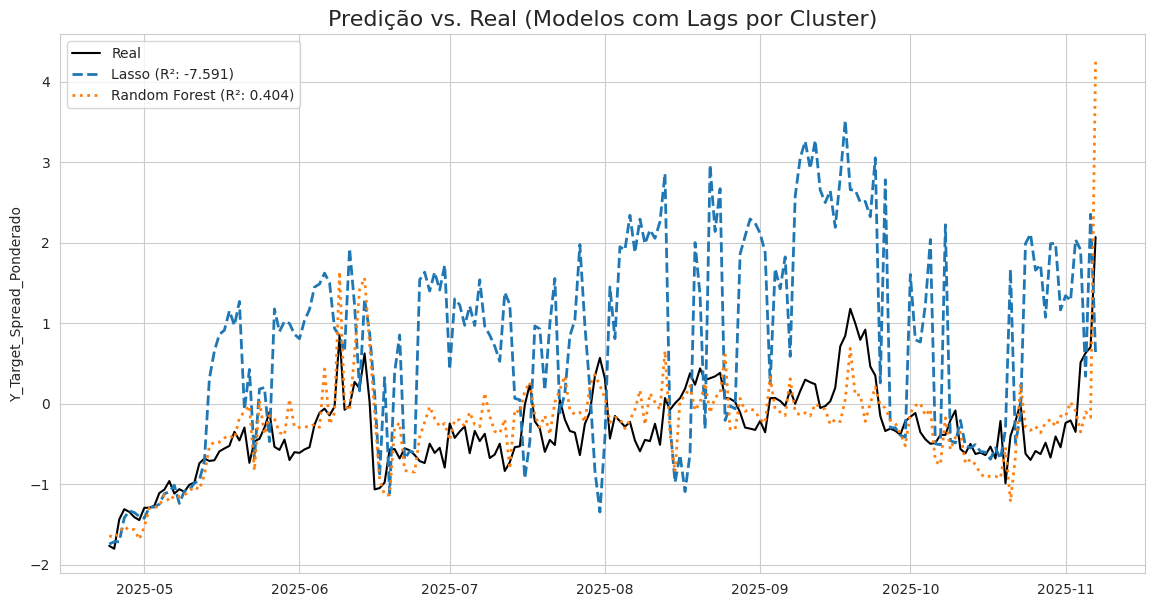

In [175]:
# Bloco Completo: Adicionando Features de Lag para Melhorar o R²

import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor # Vamos testar um modelo mais forte
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Carregar Dados ---
df = pd.read_csv('dataset_para_modelagem.csv', index_col='date', parse_dates=True)
print(f"Dataset 'dataset_para_modelagem.csv' carregado ({df.shape})")

# --- 2. Engenharia de Features (Adição de Lags) ---
print("Adicionando features de Lag (defasagem)...")
TARGET_COLUMN = 'Y_Target_Spread_Ponderado'

# Criar lags do alvo (spread de 1, 2 e 7 dias atrás)
df['X_Lag_1D'] = df[TARGET_COLUMN].shift(1)
df['X_Lag_3D'] = df[TARGET_COLUMN].shift(3)
df['X_Lag_7D'] = df[TARGET_COLUMN].shift(7)

# Remover os NaNs criados pelos lags
df_model = df.dropna()
print(f"Dataset final com Lags: {df_model.shape}")

# --- 3. Seleção de Features (Separando X_cluster de X_regress) ---

# 3.1. Features para CLUSTERIZAÇÃO (NÃO usar lags!)
# (Usamos as mesmas features de antes para encontrar os regimes)
features_cluster = [
    'X_Aave_Utilization', 'X_USDC_Depeg_Risk', 'X_VIX', 'X_DGS2', 
    'X_Gas_Price_Gwei', 'X_ETH_Returns', 'X_ETH_Vol_7D', 'X_BTC_Returns', 
    'X_BTC_Vol_7D', 'X_Gas_MA_7D', 'X_VIX_Pct_Change',
    'X_Compound_Utilization', 'X_Spread_Aave_Compound', 'X_Delta_TVL_DeFi_7D_pct'
]
# Garantir que todas existem
features_cluster = [f for f in features_cluster if f in df_model.columns]
X_cluster = df_model[features_cluster]

# 3.2. Features para REGRESSÃO (AGORA SIM, usar lags!)
features_regress = features_cluster + ['X_Lag_1D', 'X_Lag_3D', 'X_Lag_7D']
X_regress = df_model[features_regress]

# 3.3. Alvo (y)
y = df_model[TARGET_COLUMN]

# 3.4. Padronizar X_cluster (Obrigatório para KMeans)
scaler = StandardScaler()
X_cluster_scaled = scaler.fit_transform(X_cluster)
X_cluster_scaled = pd.DataFrame(X_cluster_scaled, columns=X_cluster.columns, index=X_cluster.index)

print(f"Features de Cluster: {len(features_cluster)} | Features de Regressão: {len(features_regress)}")

# --- 4. Divisão Treino/Teste ---
split_index = int(len(df_model) * 0.8)

# Dados de Cluster
X_cluster_train = X_cluster_scaled.iloc[:split_index]
X_cluster_test = X_cluster_scaled.iloc[split_index:]

# Dados de Regressão (Não padronizados para Lasso/RF)
X_regress_train = X_regress.iloc[:split_index]
X_regress_test = X_regress.iloc[split_index:]

# Alvo
y_train = y.iloc[:split_index]
y_test = y.iloc[split_index:]

# DataFrames completos
df_train = df_model.iloc[:split_index].copy()
df_test = df_model.iloc[split_index:].copy()

print(f"Divisão Treino/Teste: {len(df_train)} treino, {len(df_test)} teste.")

# --- 5. Clusterização (K=3, o vencedor) ---
N_CLUSTERS = 3
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=42, n_init=10)

print(f"\n--- Treinando K-Means (k={N_CLUSTERS}) nos dados de TREINO (sem lags) ---")
train_regimes = kmeans.fit_predict(X_cluster_train)
test_regimes = kmeans.predict(X_cluster_test)

df_train = df_train.assign(cluster=train_regimes)
df_test = df_test.assign(cluster=test_regimes)

# --- 6. Modelagem (Regressão por Cluster com Lags) ---
print("\n--- Iniciando Treinamento de Modelos por Cluster (COM Lags) ---")

models_by_cluster_lasso = {}
models_by_cluster_rf = {} # Vamos testar um RandomForest também

for cluster_id in range(N_CLUSTERS):
    print(f"\nTreinando modelo para o Cluster {cluster_id}...")
    
    # Filtrar dados de treino (AGORA USANDO X_regress_train)
    X_train_cluster = X_regress_train[df_train['cluster'] == cluster_id]
    y_train_cluster = y_train[df_train['cluster'] == cluster_id]
    
    if len(X_train_cluster) < 20: 
        print(f"Cluster {cluster_id} tem poucos dados. Pulando.")
        continue
    
    # --- Modelo 1: LassoCV (Linear) ---
    model_lasso = LassoCV(cv=5, random_state=42, max_iter=3000, n_jobs=-1)
    model_lasso.fit(X_train_cluster, y_train_cluster)
    models_by_cluster_lasso[cluster_id] = model_lasso
    print(f"Modelo Lasso para Cluster {cluster_id} treinado.")

    # --- Modelo 2: RandomForest (Não-Linear) ---
    rf_params_normal = {
            'max_depth': None, 
            'max_features': 0.8, 
            'min_samples_leaf': 1, 
            'min_samples_split': 10, 
            'n_estimators': 100,
            'random_state': 42,
            'n_jobs': -1
    }
    
    model_rf = RandomForestRegressor(**rf_params_normal)
    model_rf.fit(X_train_cluster, y_train_cluster)
    models_by_cluster_rf[cluster_id] = model_rf
    print(f"Modelo RandomForest para Cluster {cluster_id} treinado.")

# --- 7. Avaliação (Lasso com Lags) ---
print("\n--- Avaliando Modelo Lasso (com Lags) ---")
predictions_lasso = pd.Series(index=X_regress_test.index, dtype=float, name="predicted_lasso")
for cluster_id, model in models_by_cluster_lasso.items():
    if cluster_id not in df_test['cluster'].values: continue
    X_test_cluster = X_regress_test[df_test['cluster'] == cluster_id]
    if not X_test_cluster.empty:
        preds_cluster = model.predict(X_test_cluster)
        predictions_lasso.loc[X_test_cluster.index] = preds_cluster

results_lasso = pd.DataFrame({'actual': y_test, 'predicted': predictions_lasso}).dropna()
mae_lasso = mean_absolute_error(results_lasso['actual'], results_lasso['predicted'])
r2_lasso = r2_score(results_lasso['actual'], results_lasso['predicted'])

print(f"Resultados (Lasso com Lags): MAE = {mae_lasso:.4f} | R² = {r2_lasso:.4f}")

# --- 8. Avaliação (RandomForest com Lags) ---
print("\n--- Avaliando Modelo RandomForest (com Lags) ---")
predictions_rf = pd.Series(index=X_regress_test.index, dtype=float, name="predicted_rf")
for cluster_id, model in models_by_cluster_rf.items():
    if cluster_id not in df_test['cluster'].values: continue
    X_test_cluster = X_regress_test[df_test['cluster'] == cluster_id]
    if not X_test_cluster.empty:
        preds_cluster = model.predict(X_test_cluster)
        predictions_rf.loc[X_test_cluster.index] = preds_cluster

results_rf = pd.DataFrame({'actual': y_test, 'predicted': predictions_rf}).dropna()
mae_rf = mean_absolute_error(results_rf['actual'], results_rf['predicted'])
r2_rf = r2_score(results_rf['actual'], results_rf['predicted'])

print(f"Resultados (RandomForest com Lags): MAE = {mae_rf:.4f} | R² = {r2_rf:.4f}")

# --- 9. Plotar Comparação Final ---
plt.figure(figsize=(14, 7))
plt.plot(results_lasso['actual'], label='Real', color='black', linewidth=1.5)
plt.plot(results_lasso['predicted'], label=f'Lasso (R²: {r2_lasso:.3f})', linestyle='--', linewidth=2)
plt.plot(results_rf['predicted'], label=f'Random Forest (R²: {r2_rf:.3f})', linestyle=':', linewidth=2)
plt.title(f'Predição vs. Real (Modelos com Lags por Cluster)', fontsize=16)
plt.ylabel(TARGET_COLUMN)
plt.legend()
plt.plot()
plt.show()

In [176]:
# Bloco Final: Interpretação dos Modelos

print("--- Importância das Features (Modelos RandomForest) ---")
# Loop pelos modelos RF que você treinou (models_by_cluster_rf)

for cluster_id, model in models_by_cluster_rf.items():
    print(f"\n--- Cluster {cluster_id} (RandomForest) ---")
    
    # Criar um DataFrame de importância das features
    importances = pd.DataFrame(
        data=model.feature_importances_, 
        index=X_regress_train.columns,  # Usar colunas do X_regress
        columns=['Importance']
    ).sort_values(by='Importance', ascending=False)
    
    # Mostrar as 5 features mais importantes
    print(importances.head(5))

print("\n" + "="*30 + "\n")

print("--- Coeficientes (Modelos Lasso) ---")
# Loop pelos modelos Lasso que você treinou (models_by_cluster_lasso)
for cluster_id, model in models_by_cluster_lasso.items():
    print(f"\n--- Cluster {cluster_id} (Lasso) ---")
    
    # Criar um DataFrame de coeficientes
    coefs = pd.DataFrame(
        data=model.coef_, 
        index=X_regress_train.columns, # Usar colunas do X_regress
        columns=['Coefficient']
    )
    
    # Mostrar os 5 maiores coeficientes (positivos ou negativos)
    # Filtra coeficientes que não são zero
    coefs_nonzero = coefs[coefs['Coefficient'] != 0]
    # Ordena pelo valor absoluto
    coefs_sorted = coefs_nonzero.reindex(coefs_nonzero['Coefficient'].abs().sort_values(ascending=False).index)
    
    print(coefs_sorted.head(5))

--- Importância das Features (Modelos RandomForest) ---

--- Cluster 0 (RandomForest) ---
                        Importance
X_Spread_Aave_Compound    0.422904
X_Aave_Utilization        0.389555
X_Lag_7D                  0.147766
X_Lag_1D                  0.014569
X_Lag_3D                  0.011068

--- Cluster 1 (RandomForest) ---
             Importance
X_Lag_1D       0.575491
X_Lag_3D       0.193333
X_Gas_MA_7D    0.067964
X_Lag_7D       0.053590
X_DGS2         0.048865

--- Cluster 2 (RandomForest) ---
                        Importance
X_Aave_Utilization        0.521274
X_Spread_Aave_Compound    0.295073
X_Lag_1D                  0.123385
X_Lag_7D                  0.030375
X_Lag_3D                  0.011992


--- Coeficientes (Modelos Lasso) ---

--- Cluster 0 (Lasso) ---
                        Coefficient
X_Spread_Aave_Compound     0.539435
X_Lag_7D                   0.356694
X_Compound_Utilization     0.214461
X_Lag_3D                   0.080224
X_Lag_1D                   0.057

In [177]:
# Bloco de Análise: Performance por Cluster (k=3)

import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Carregar Dados ---
# (Assumindo que 'dataset_para_modelagem.csv' está salvo)
try:
    df = pd.read_csv('dataset_para_modelagem.csv', index_col='date', parse_dates=True)
except FileNotFoundError:
    print("ERRO: 'dataset_para_modelagem.csv' não encontrado.")
    print("Por favor, rode o Bloco 2 (Engenharia de Features) primeiro.")
    # Se der erro, pare aqui
    raise

# --- 2. Recriar Features de Lag ---
TARGET_COLUMN = 'Y_Target_Spread_Ponderado'
df['X_Lag_1D'] = df[TARGET_COLUMN].shift(1)
df['X_Lag_3D'] = df[TARGET_COLUMN].shift(3)
df['X_Lag_7D'] = df[TARGET_COLUMN].shift(7)
df_model = df.dropna()

# --- 3. Seleção de Features (Cluster vs. Regressão) ---
features_cluster = [
    'X_Aave_Utilization', 'X_USDC_Depeg_Risk', 'X_VIX', 'X_DGS2', 
    'X_Gas_Price_Gwei', 'X_ETH_Returns', 'X_ETH_Vol_7D', 'X_BTC_Returns', 
    'X_BTC_Vol_7D', 'X_Gas_MA_7D', 'X_VIX_Pct_Change',
    'X_Compound_Utilization', 'X_Spread_Aave_Compound', 'X_Delta_TVL_DeFi_7D_pct'
]
features_cluster = [f for f in features_cluster if f in df_model.columns]
X_cluster = df_model[features_cluster]

features_regress = features_cluster + ['X_Lag_1D', 'X_Lag_3D', 'X_Lag_7D']
X_regress = df_model[features_regress]
y = df_model[TARGET_COLUMN]

scaler = StandardScaler()
X_cluster_scaled = scaler.fit_transform(X_cluster)
X_cluster_scaled = pd.DataFrame(X_cluster_scaled, columns=X_cluster.columns, index=X_cluster.index)

# --- 4. Divisão Treino/Teste ---
split_index = int(len(df_model) * 0.8)
X_cluster_train = X_cluster_scaled.iloc[:split_index]
X_cluster_test = X_cluster_scaled.iloc[split_index:]
X_regress_train = X_regress.iloc[:split_index]
X_regress_test = X_regress.iloc[split_index:]
y_train = y.iloc[:split_index]
y_test = y.iloc[split_index:]
df_train = df_model.iloc[:split_index].copy()
df_test = df_model.iloc[split_index:].copy()

# --- 5. Clusterização (K=3) ---
N_CLUSTERS = 3
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=42, n_init=10)
train_regimes = kmeans.fit_predict(X_cluster_train)
test_regimes = kmeans.predict(X_cluster_test)
df_train = df_train.assign(cluster=train_regimes)
df_test = df_test.assign(cluster=test_regimes)

# --- 6. Modelagem (Apenas RandomForest, o vencedor) ---
models_by_cluster_rf = {}
for cluster_id in range(N_CLUSTERS):
    X_train_cluster = X_regress_train[df_train['cluster'] == cluster_id]
    y_train_cluster = y_train[df_train['cluster'] == cluster_id]
    if len(X_train_cluster) < 20: 
        models_by_cluster_rf[cluster_id] = None # Marcar como nulo se não houver dados
        continue
    model_rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, max_depth=5)
    model_rf.fit(X_train_cluster, y_train_cluster)
    models_by_cluster_rf[cluster_id] = model_rf

# --- 7. Geração de Predições (RF) ---
predictions_rf = pd.Series(index=X_regress_test.index, dtype=float, name="predicted_rf")
for cluster_id, model in models_by_cluster_rf.items():
    if model is None: continue # Pular se o modelo não foi treinado
    if cluster_id not in df_test['cluster'].values: continue
    
    X_test_cluster = X_regress_test[df_test['cluster'] == cluster_id]
    if not X_test_cluster.empty:
        preds_cluster = model.predict(X_test_cluster)
        predictions_rf.loc[X_test_cluster.index] = preds_cluster

# --- 8. ANÁLISE POR CLUSTER (Sua Solicitação) ---
print("\n" + "="*50)
print("--- Performance de TESTE Detalhada por Cluster (Modelo RandomForest) ---")

# Juntar predições, reais e labels de cluster
results_rf = pd.DataFrame({'actual': y_test, 'predicted': predictions_rf})
results_rf = results_rf.join(df_test['cluster']).dropna()

cluster_performance = []

# Loop pelos clusters 0, 1, 2
for cluster_id in range(N_CLUSTERS):
    
    # Filtrar o dataframe de resultados para este cluster
    cluster_df = results_rf[results_rf['cluster'] == cluster_id]
    
    count = len(cluster_df)
    
    # Calcular métricas apenas se houver pontos suficientes
    if count < 2:
        mae = np.nan
        r2 = np.nan
    else:
        mae = mean_absolute_error(cluster_df['actual'], cluster_df['predicted'])
        r2 = r2_score(cluster_df['actual'], cluster_df['predicted'])
        
    cluster_performance.append({
        'Cluster': cluster_id,
        'Pontos_no_Teste': count,
        'MAE': mae,
        'R2': r2
    })

# Imprimir tabela final
performance_df = pd.DataFrame(cluster_performance).set_index('Cluster')
print("--- Tabela Resumo da Performance (Conjunto de Teste) ---")
print(performance_df.to_markdown(floatfmt=".4f"))
print("="*50)

# Imprimir Métricas Globais (para referência)
mae_global = mean_absolute_error(results_rf['actual'], results_rf['predicted'])
r2_global = r2_score(results_rf['actual'], results_rf['predicted'])
print(f"\nMAE Global (Teste): {mae_global:.4f}")
print(f"R² Global (Teste):  {r2_global:.4f}")


--- Performance de TESTE Detalhada por Cluster (Modelo RandomForest) ---
--- Tabela Resumo da Performance (Conjunto de Teste) ---
|   Cluster |   Pontos_no_Teste |    MAE |       R2 |
|----------:|------------------:|-------:|---------:|
|         0 |            7.0000 | 0.4420 | -14.6345 |
|         1 |           48.0000 | 0.2135 |   0.7360 |
|         2 |          143.0000 | 0.4942 |  -0.4636 |

MAE Global (Teste): 0.4243
R² Global (Teste):  0.0734
